
# Housing Prices vs. Unemployment Trends in California

This notebook replicates the analysis and visualisation workflow described in the accompanying report.  It processes three datasets:

- `fhfa_hpi.csv` (FHFA House‑Price Index)【529491019350522†L81-L85】;
- `kaggle_real_estate.csv` (Zillow median home values, days on market, price cuts);
- `laus.csv` (Local Area Unemployment Statistics for California)【991720848600251†L84-L105】.

The notebook performs the following steps:

1. Loads and cleans each dataset.
2. Merges them on a common monthly date column.
3. Computes derived variables (percentage changes and categorical groups).
4. Filters subsets of interest (pandemic period, unemployment thresholds, price tiers, combined conditions, seasonal subsets).
5. Sorts the data in various ways to highlight extremes.
6. Generates a suite of visualisations.
7. Builds pivot tables and demonstrates stacking/unstacking.
8. Computes correlations to summarise relationships.

Run all cells sequentially to reproduce the analysis and figures.


In [83]:

#Import the needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [84]:

# Load data from file
df_hpi = pd.read_csv('Databases/fhfa_hpi.csv')
df_real_estate = pd.read_csv('Databases/kaggle_real_estate.csv')
df_laus = pd.read_csv('Databases/laus.csv')

# Size of datasets
print('HPI shape:', df_hpi.shape)
print('Real Estate shape:', df_real_estate.shape)
print('LAUS shape:', df_laus.shape)


HPI shape: (132363, 10)
Real Estate shape: (895, 232)
LAUS shape: (215048, 12)


In [85]:

# Filter to California state level and average duplicate entries
hpi_ca = df_hpi[(df_hpi['level'].str.lower() == 'state') & (df_hpi['place_name'] == 'California')].copy()

# Create a date column
hpi_ca['date'] = pd.to_datetime(hpi_ca['yr']*100 + hpi_ca['period'], format='%Y%m')

# Average index across duplicates for the same date
hpi_ca = hpi_ca[['date', 'index_sa']].groupby('date', as_index=False).mean()

#Drop the null columns
hpi_ca.dropna(inplace=True)

hpi_ca

,date,index_sa
64,1991-01-01,100.000
65,1991-02-01,99.535
66,1991-03-01,99.480
67,1991-04-01,99.725
68,1992-01-01,99.460
...,...,...
198,2024-03-01,422.395
199,2024-04-01,426.555
200,2025-01-01,428.835
201,2025-02-01,426.105


In [86]:

# Identify the date-value columns that need to be melted
value_vars = [x for x in df_real_estate.columns if '-' in x]

# Melt columns
df_re_melted = df_real_estate.melt(id_vars=['RegionID','RegionName','StateName'],
                          value_vars=value_vars,
                          var_name='date-name', value_name='value')

# Split 'date-name' into date and name
df_re_melted[['date','name']] = df_re_melted['date-name'].str.rsplit('-', n=1, expand=True)

#Make date a datetime value
df_re_melted['date'] = pd.to_datetime(df_re_melted['date'], format='%Y-%m')
# Filter so that only California remains
df_re_ca = df_re_melted[df_re_melted['StateName'] == 'CA']

# Pivot the dataframe to get the avg for each date for each name
df_re_main = df_re_ca.pivot_table(index='date', columns='name', values='value', aggfunc='mean').reset_index()

# Rename columns for easier usage
df_re_main.rename(columns={'HomeValue':'home_value', 'DaysPending':'days_pending', 'CutRaw':'cut_raw'}, inplace=True)

#Make sure there are no missing values
df_re_main.dropna(inplace=True)

df_re_main

name,date,cut_raw,days_pending,home_value
0,2018-02-01,16109.523810,40.642857,426126.500684
1,2018-03-01,16143.190476,37.321429,430110.851559
2,2018-04-01,17580.404762,36.285714,433698.712450
3,2018-05-01,17914.357143,34.321429,437143.119717
4,2018-06-01,17221.571429,38.892857,439843.879635
...,...,...,...,...
71,2024-01-01,19510.032258,53.032258,609553.845818
72,2024-02-01,20730.112903,47.967742,609715.237576
73,2024-03-01,21678.838710,43.225806,611862.298184
74,2024-04-01,22569.741935,38.500000,615631.512863


In [87]:

# Filter to California state and seasonally adjusted values
laus_state = df_laus[(df_laus['Area Type'] == 'State') & 
                  (df_laus['Area Name'] == 'California') &
                  (df_laus['Seasonally Adjusted(Y/N)'] == 'Y')].copy()

# Filter dates into a date column and drop numeric dates column
laus_state['date'] = pd.to_datetime(laus_state.Date_Numeric, format='%m/%Y');
laus_state.drop(columns=['Date_Numeric'], inplace=True)

# Rename the important uer row to naming convention
laus_state.rename(columns={"Unemployment Rate" : 'unemployment_rate'}, inplace=True)

# Make sure uer is a float
laus_state['unemployment_rate'] = laus_state['unemployment_rate'].astype(float)

#Group and sort by date
laus_state = laus_state[['date', 'unemployment_rate']].dropna().sort_values('date')

laus_state


,date,unemployment_rate
1,1976-01-01,9.2
3,1976-02-01,9.2
5,1976-03-01,9.1
7,1976-04-01,9.1
9,1976-05-01,9.0
...,...,...
210871,2025-04-01,5.3
211895,2025-05-01,5.3
212919,2025-06-01,5.4
214885,2025-07-01,5.5


In [88]:

# Merge the HPI, LAUS, and Real Estate datasets on date
df_merged = pd.merge(hpi_ca, laus_state, on='date', how='inner') 
df_merged = pd.merge(df_merged, df_re_main, on='date', how='inner')

# Sort by the date
df_merged = df_merged.sort_values('date').reset_index(drop=True)

df_merged


,date,index_sa,unemployment_rate,cut_raw,days_pending,home_value
0,2018-02-01,274.160,4.3,16109.523810,40.642857,426126.500684
1,2018-03-01,277.525,4.3,16143.190476,37.321429,430110.851559
2,2018-04-01,279.715,4.2,17580.404762,36.285714,433698.712450
3,2019-01-01,281.885,4.3,13517.333333,68.965517,448079.284427
4,2019-02-01,284.870,4.3,14054.809524,62.827586,448205.444633
5,2019-03-01,287.910,4.2,13903.976190,56.586207,448768.263765
6,2019-04-01,291.445,4.1,15346.404762,47.827586,449427.792805
7,2020-01-01,297.115,4.3,15437.238095,69.206897,459588.404542
8,2020-02-01,297.480,4.4,15461.904762,54.620690,461515.345789
9,2020-03-01,309.220,5.5,16735.666667,45.103448,463845.548129


In [89]:

# Get percentage changes
df_merged['hpi_pct_change'] = df_merged['index_sa'].pct_change()
df_merged['unemp_pct_change'] = df_merged['unemployment_rate'].pct_change()
df_merged['home_value_pct_change'] = df_merged['home_value'].pct_change()
df_merged['days_pending_pct_change'] = df_merged['days_pending'].pct_change()

# Separate date into year, quarter, month
df_merged['year'] = df_merged['date'].dt.year
df_merged['month'] = df_merged['date'].dt.month
df_merged['quarter'] = df_merged['date'].dt.quarter

# Categorize groups for unemployment and price tiers
df_merged['unemp_group'] = pd.cut(df_merged['unemployment_rate'], bins=[-np.inf, 5, 7, np.inf], labels=['low','medium','high'])
quantiles = df_merged['home_value'].quantile([0.25, 0.75]).values
bins_price = [-np.inf, quantiles[0], quantiles[1], np.inf]
df_merged['price_tier'] = pd.cut(df_merged['home_value'], bins=bins_price, labels=['low','middle','high'])

df_merged


,date,index_sa,unemployment_rate,cut_raw,days_pending,home_value,hpi_pct_change,unemp_pct_change,home_value_pct_change,days_pending_pct_change,year,month,quarter,unemp_group,price_tier
0,2018-02-01,274.160,4.3,16109.523810,40.642857,426126.500684,NaN,NaN,NaN,NaN,2018,2,1,low,low
1,2018-03-01,277.525,4.3,16143.190476,37.321429,430110.851559,0.012274,0.000000,0.009350,-0.081722,2018,3,1,low,low
2,2018-04-01,279.715,4.2,17580.404762,36.285714,433698.712450,0.007891,-0.023256,0.008342,-0.027751,2018,4,2,low,low
3,2019-01-01,281.885,4.3,13517.333333,68.965517,448079.284427,0.007758,0.023810,0.033158,0.900624,2019,1,1,low,low
4,2019-02-01,284.870,4.3,14054.809524,62.827586,448205.444633,0.010589,0.000000,0.000282,-0.089000,2019,2,1,low,low
5,2019-03-01,287.910,4.2,13903.976190,56.586207,448768.263765,0.010672,-0.023256,0.001256,-0.099341,2019,3,1,low,low
6,2019-04-01,291.445,4.1,15346.404762,47.827586,449427.792805,0.012278,-0.023810,0.001470,-0.154784,2019,4,2,low,low
7,2020-01-01,297.115,4.3,15437.238095,69.206897,459588.404542,0.019455,0.048780,0.022608,0.447008,2020,1,1,low,middle
8,2020-02-01,297.480,4.4,15461.904762,54.620690,461515.345789,0.001228,0.023256,0.004193,-0.210762,2020,2,1,low,middle
9,2020-03-01,309.220,5.5,16735.666667,45.103448,463845.548129,0.039465,0.250000,0.005049,-0.174242,2020,3,1,medium,middle


In [90]:

# Pandemic period (2020+)
pandemic_subset = df_merged[df_merged['date'] >= '2020-01-01']

# Unemployment thresholds
low_unemp = df_merged[df_merged['unemp_group'] == 'low']
medium_unemp = df_merged[df_merged['unemp_group'] == 'medium']
high_unemp = df_merged[df_merged['unemp_group'] == 'high']

# Price tiers
low_price = df_merged[df_merged['price_tier'] == 'low']
middle_price = df_merged[df_merged['price_tier'] == 'middle']
high_price = df_merged[df_merged['price_tier'] == 'high']

# Combined conditions (unemployment >6% and negative HPI growth)
combined_cond = df_merged[(df_merged['unemployment_rate'] > 6) & (df_merged['hpi_pct_change'] < 0)]

# Seasonal subsets (Quarter 1 and Quarter 3)
q1_subset = df_merged[df_merged['quarter'] == 1]
q3_subset = df_merged[df_merged['quarter'] == 3]

#This data was handled by direct reading of the data with excel

In [91]:

# Add deviation from mean unemployment for sorting
df_merged['unemp_deviation'] = (df_merged['unemployment_rate'] - df_merged['unemployment_rate'].mean()).abs()

# Sorting examples
df_date_desc = df_merged.sort_values('date', ascending=False).head(5)
df_home_desc = df_merged.sort_values('home_value', ascending=False).head(5)
df_unemp_asc = df_merged.sort_values('unemployment_rate').head(5)
df_hpi_growth = df_merged.sort_values('hpi_pct_change', ascending=False).head(5)
df_unemp_dev = df_merged.sort_values('unemp_deviation', ascending=False).head(5)

# Display the sorted heads
print('Recent months:', df_date_desc[['date','index_sa','unemployment_rate','home_value']])
print('Highest home values:', df_home_desc[['date','home_value','index_sa','unemployment_rate']])
print('Lowest unemployment:', df_unemp_asc[['date','unemployment_rate','home_value','index_sa']])
print('Highest HPI growth:', df_hpi_growth[['date','hpi_pct_change','index_sa','unemployment_rate']])
print('Largest unemployment deviations:', df_unemp_dev[['date','unemployment_rate','unemp_deviation','index_sa','home_value']])


Recent months:          date  index_sa  unemployment_rate     home_value
26 2024-04-01   426.555                5.2  615631.512863
25 2024-03-01   422.395                5.1  611862.298184
24 2024-02-01   419.230                5.1  609715.237576
23 2024-01-01   417.230                5.1  609553.845818
22 2023-04-01   413.215                4.5  587404.451859
Highest home values:          date     home_value  index_sa  unemployment_rate
18 2022-04-01  617703.017466   396.055                4.3
26 2024-04-01  615631.512863   426.555                5.2
25 2024-03-01  611862.298184   422.395                5.1
24 2024-02-01  609715.237576   419.230                5.1
23 2024-01-01  609553.845818   417.230                5.1
Lowest unemployment:         date  unemployment_rate     home_value  index_sa
6 2019-04-01                4.1  449427.792805   291.445
2 2018-04-01                4.2  433698.712450   279.715
5 2019-03-01                4.2  448768.263765   287.910
0 2018-02-01       

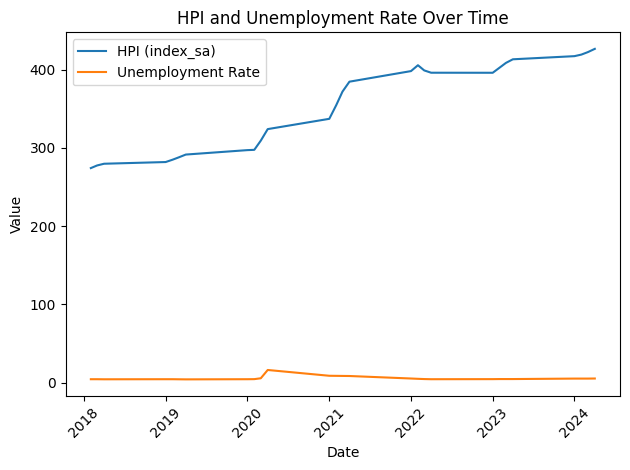

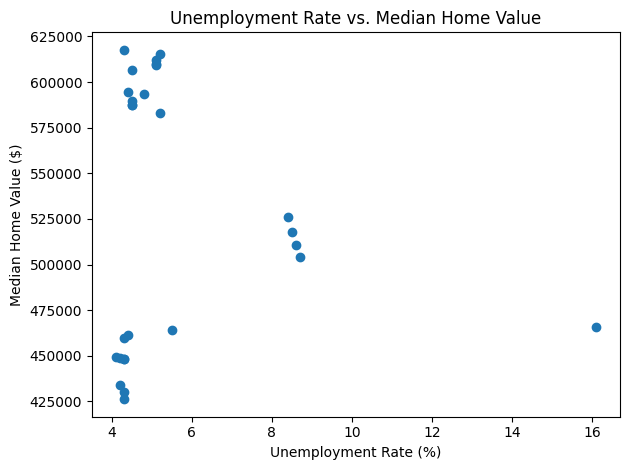

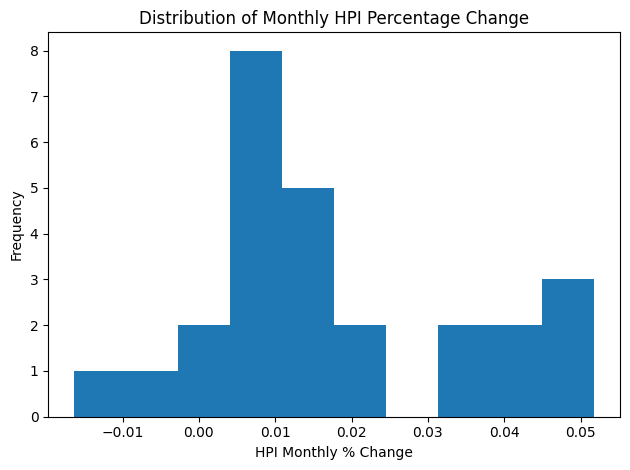

<Figure size 640x480 with 0 Axes>

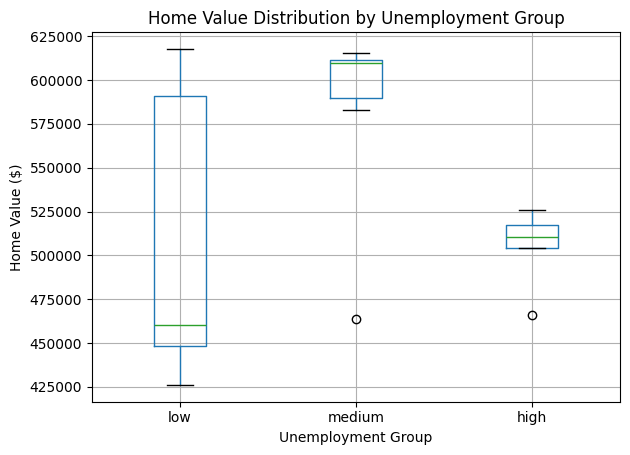

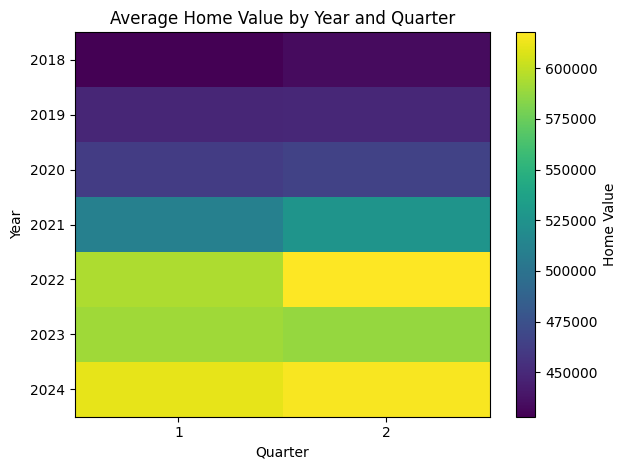

In [92]:

# HPI and Unemployment Rate over Time
plt.figure()
plt.plot(df_merged['date'], df_merged['index_sa'], label='HPI (index_sa)')
plt.plot(df_merged['date'], df_merged['unemployment_rate'], label='Unemployment Rate')
plt.legend()
plt.title('HPI and Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plot: Unemployment vs Home Value
plt.figure()
plt.scatter(df_merged['unemployment_rate'], df_merged['home_value'])
plt.title('Unemployment Rate vs. Median Home Value')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Median Home Value ($)')
plt.tight_layout()
plt.show()

# Histogram of HPI percentage change
plt.figure()
plt.hist(df_merged['hpi_pct_change'].dropna(), bins=10)
plt.title('Distribution of Monthly HPI Percentage Change')
plt.xlabel('HPI Monthly % Change')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot of Home Value by Unemployment Group
plt.figure()
df_merged.boxplot(column='home_value', by='unemp_group')
plt.title('Home Value Distribution by Unemployment Group')
plt.suptitle('')
plt.xlabel('Unemployment Group')
plt.ylabel('Home Value ($)')
plt.tight_layout()
plt.show()

# Heatmap of Average Home Value by Year and Quarter
pivot_home = df_merged.pivot_table(index='year', columns='quarter', values='home_value', aggfunc='mean')
plt.figure()
plt.imshow(pivot_home, aspect='auto')
plt.title('Average Home Value by Year and Quarter')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.xticks(ticks=np.arange(len(pivot_home.columns)), labels=pivot_home.columns)
plt.yticks(ticks=np.arange(len(pivot_home.index)), labels=pivot_home.index)
plt.colorbar(label='Home Value')
plt.tight_layout()
plt.show()


In [93]:

# Average home value by year and quarter
pivot1 = df_merged.pivot_table(index='year', columns='quarter', values='home_value', aggfunc='mean')
print('Pivot1 - Home value by year and quarter:')
display(pivot1)

# Average unemployment rate by year and quarter
pivot2 = df_merged.pivot_table(index='year', columns='quarter', values='unemployment_rate', aggfunc='mean')
print('Pivot2 - Unemployment rate by year and quarter:')
display(pivot2)

# Average days pending by unemployment group and price tier
pivot3 = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')
print('Pivot3 - Days pending by unemp group and price tier:')
display(pivot3)

# Multi-index pivot of home value by year and unemp group, stack and unstack
pivot4 = df_merged.pivot_table(index=['year','unemp_group'], columns='price_tier', values='home_value', aggfunc='mean')
stacked = pivot4.stack()
unstacked = stacked.unstack(level=1)
print('Pivot4 - Stacked and unstacked:')
display(stacked)
display(unstacked)

# Count of records by unemployment group and price tier
pivot5 = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='date', aggfunc='count')
print('Pivot5 - Counts by unemp group and price tier:')
display(pivot5)


Pivot1 - Home value by year and quarter:


quarter,1,2
year,,
2018,428118.676121,433698.712450
2019,448350.997608,449427.792805
2020,461649.766153,465766.869179
2021,510792.831820,525874.028486
2022,594364.286820,617703.017466
2023,590488.690366,587404.451859
2024,610377.127193,615631.512863


Pivot2 - Unemployment rate by year and quarter:


quarter,1,2
year,,
2018,4.300000,4.2
2019,4.266667,4.1
2020,4.733333,16.1
2021,8.600000,8.4
2022,4.833333,4.3
2023,4.466667,4.5
2024,5.100000,5.2


Pivot3 - Days pending by unemp group and price tier:


C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\3285608179.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot3 = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')


price_tier,low,middle,high
unemp_group,,,
low,50.065271,47.373563,33.609195
medium,NaN,39.379310,45.681452
high,NaN,32.006897,NaN


Pivot4 - Stacked and unstacked:


C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\3285608179.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot4 = df_merged.pivot_table(index=['year','unemp_group'], columns='price_tier', values='home_value', aggfunc='mean')


year  unemp_group  price_tier
2018  low          low           429978.688231
2019  low          low           448620.196408
2020  low          middle        460551.875165
      medium       middle        463845.548129
      high         middle        465766.869179
2021  high         middle        514563.130986
2022  low          middle        593539.574788
                   high          612035.713214
      medium       middle        583184.876710
2023  low          middle        588147.257035
                   high          594428.751854
2024  medium       high          611690.723610
dtype: float64

unemp_group                low         medium           high
year price_tier                                             
2018 low         429978.688231            NaN            NaN
2019 low         448620.196408            NaN            NaN
2020 middle      460551.875165  463845.548129  465766.869179
2021 middle                NaN            NaN  514563.130986
2022 middle      593539.574788  583184.876710            NaN
     high        612035.713214            NaN            NaN
2023 middle      588147.257035            NaN            NaN
     high        594428.751854            NaN            NaN
2024 high                  NaN  611690.723610            NaN

Pivot5 - Counts by unemp group and price tier:


C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\3285608179.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot5 = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='date', aggfunc='count')


price_tier,low,middle,high
unemp_group,,,
low,7,6,3
medium,0,2,4
high,0,5,0


In [94]:

# Correlations
df_corr_hpi_unemp = df_merged['index_sa'].corr(df_merged['unemployment_rate'])
df_corr_home_unemp = df_merged['home_value'].corr(df_merged['unemployment_rate'])
df_corr_hpi_pchange_unemp = df_merged['hpi_pct_change'].corr(df_merged['unemployment_rate'])
df_corr_home_pchange_unemp = df_merged['home_value_pct_change'].corr(df_merged['unemployment_rate'])

print('Correlation between HPI index and unemployment rate:', df_corr_hpi_unemp)
print('Correlation between median home value and unemployment rate:', df_corr_home_unemp)
print('Correlation between HPI monthly % change and unemployment rate:', df_corr_hpi_pchange_unemp)
print('Correlation between home value monthly % change and unemployment rate:', df_corr_home_pchange_unemp)


Correlation between HPI index and unemployment rate: 0.019962622865576627
Correlation between median home value and unemployment rate: -0.10879709038967766
Correlation between HPI monthly % change and unemployment rate: 0.710518823796223
Correlation between home value monthly % change and unemployment rate: 0.1223835423971852


In [96]:

# Identify top 5 months by HPI monthly percentage change
# hpi_pct_change was computed earlier; ensure it's available
# Some values may be NaN; drop them before sorting
top_growth = df_merged.dropna(subset=['hpi_pct_change']).sort_values('hpi_pct_change', ascending=False).head(5)

# Identify top 5 months by median home value
top_home = df_merged.sort_values('home_value', ascending=False).head(5)

# Create pivot tables for days pending and counts
pivot_days_pending = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')
pivot_counts = df_merged.groupby(['unemp_group', 'price_tier']).size().unstack(fill_value=0)

C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\4005410016.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_days_pending = df_merged.pivot_table(index='unemp_group', columns='price_tier', values='days_pending', aggfunc='mean')
C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\4005410016.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_counts = df_merged.groupby(['unemp_group', 'price_tier']).size().unstack(fill_value=0)


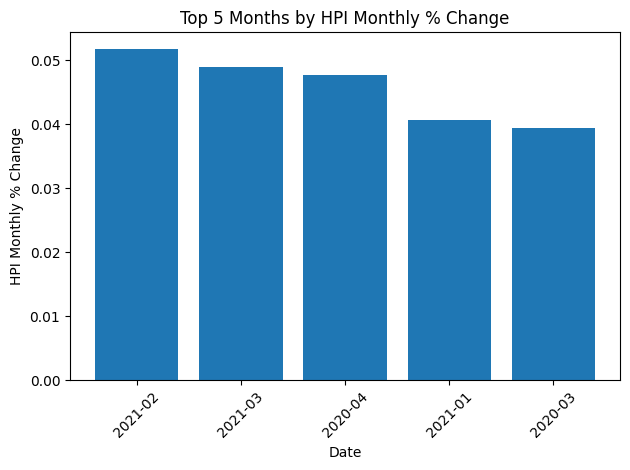

In [97]:
plt.figure()
plt.bar(top_growth['date'].dt.strftime('%Y-%m'), top_growth['hpi_pct_change'])
plt.title('Top 5 Months by HPI Monthly % Change')
plt.xlabel('Date')
plt.ylabel('HPI Monthly % Change')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

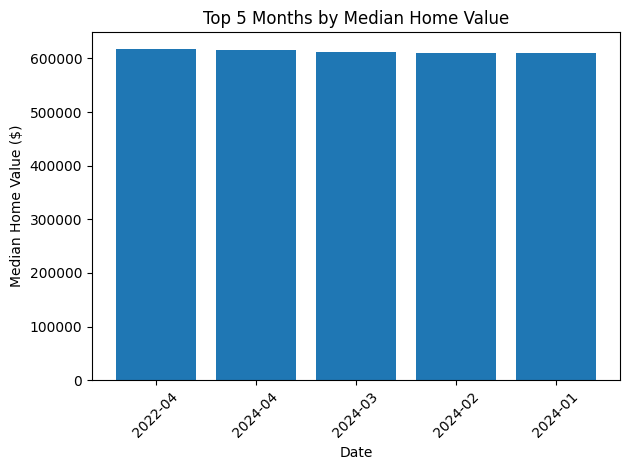

In [98]:
# Bar chart: Top 5 months by median home value
plt.figure()
plt.bar(top_home['date'].dt.strftime('%Y-%m'), top_home['home_value'])
plt.title('Top 5 Months by Median Home Value')
plt.xlabel('Date')
plt.ylabel('Median Home Value ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\zimin\AppData\Local\Temp\ipykernel_72600\3635847333.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_index = df_merged.groupby(['date', 'unemp_group'])['index_sa'].mean().unstack()


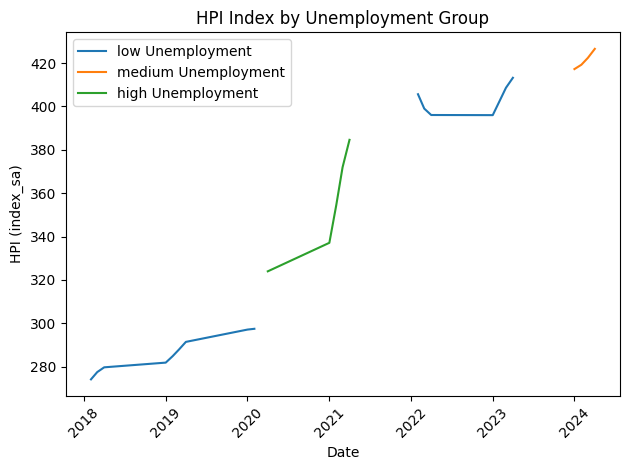

In [100]:
# Line chart: HPI index by unemployment group
# Compute mean index by unemployment group for each date
grouped_index = df_merged.groupby(['date', 'unemp_group'])['index_sa'].mean().unstack()
plt.figure()
for group in grouped_index.columns:
    plt.plot(grouped_index.index, grouped_index[group], label=f'{group} Unemployment')
plt.title('HPI Index by Unemployment Group')
plt.xlabel('Date')
plt.ylabel('HPI (index_sa)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

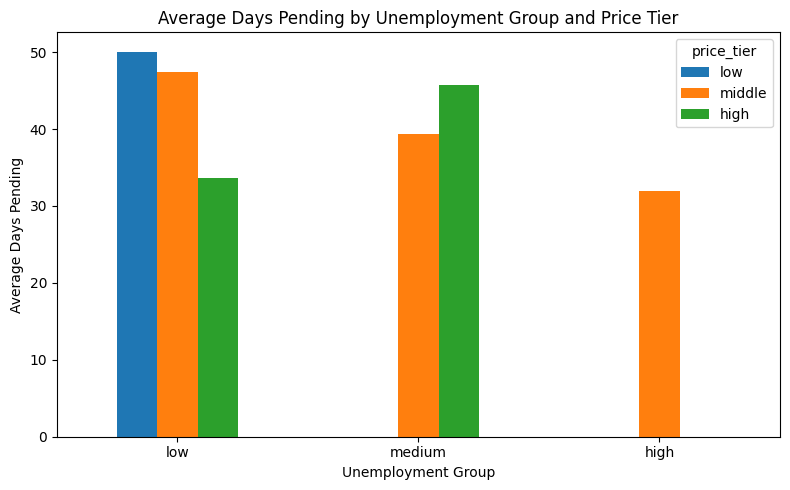

In [101]:
# Grouped bar chart: Average days pending by unemployment group and price tier
plt.figure()
pivot_days_pending.plot(kind='bar', figsize=(8, 5))
plt.title('Average Days Pending by Unemployment Group and Price Tier')
plt.xlabel('Unemployment Group')
plt.ylabel('Average Days Pending')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

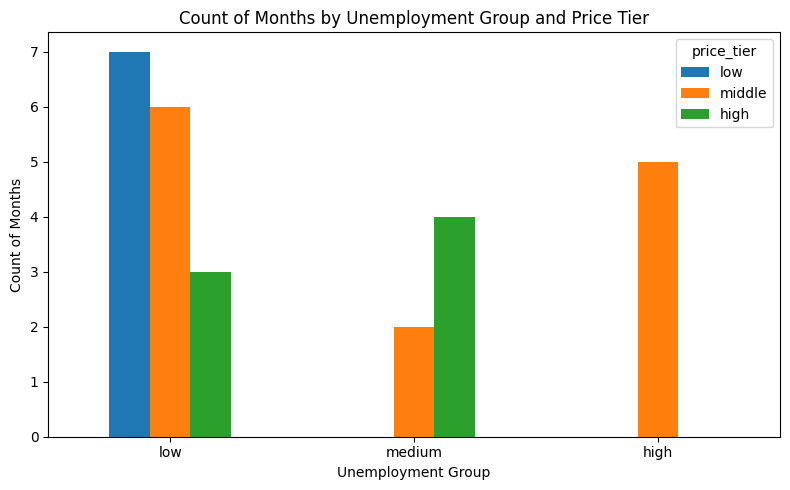

In [102]:
# Bar chart: Count of months by unemployment group and price tier
plt.figure()
pivot_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Count of Months by Unemployment Group and Price Tier')
plt.xlabel('Unemployment Group')
plt.ylabel('Count of Months')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()